In [4]:
import os
import math
import json
import datetime
import numpy as np

from tifffile import tifffile

from skimage import morphology, filters, transform, measure
from skimage.feature import peak_local_max

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mp
from matplotlib import cm

from scipy import stats, optimize
from scipy.interpolate import interp1d

def plane(X, a, b, c):
    return(a*X[0] + b * X[1] + c)

def delayed_exponential_on(t, b, tau, upper_lim, lower_lim):
    de = upper_lim - (upper_lim - lower_lim) * np.exp(b*(t - tau))
    de[t < tau] = lower_lim
    return(de)


def delayed_exponential_on_off(t, b_on, b_off, tau_on, tau_off, upper_lim, lower_lim, lower_lim2):
    de = upper_lim - (upper_lim - lower_lim) * np.exp(b_on*(t - tau_on))
    de[t < tau_on] = lower_lim
    
    val = upper_lim - (upper_lim - lower_lim) * np.exp(b_on*(tau_off - tau_on))
    de[t > tau_off] =  lower_lim2 + (val - lower_lim2) * np.exp(b_off*(t[t > tau_off] - tau_off))
    return(de)
        
        
class mm_microscope_image:
    def __init__(self, path):
        self.filepath = path
        self.array = None
        self.framenumber = None
        self.elapsed_time_s = None
        self.channel = None
        self.pixelsizeum = None
        self.md = None
        self.H = None
        self.W = None

        with tifffile.TiffFile(path) as tif:
            try:
                md = json.loads(tif.imagej_metadata["Info"])
                self.md = md
                self.array = tif.asarray()
                self.framenumber = None
                self.elapsed_time_s = md['ElapsedTime-ms']/1000.
                self.channel = None
                try:
                    self.pixelsizeum = md['PixelSize_um']
                except:
                    self.pixelsizeum = md['PixelSizeUm']
                self.H = md['Width']
                self.W = md['Height']
                self.stage_x = md['XPositionUm']
                self.stage_y = md['YPositionUm']
            except:
                self.md = tif.shaped_metadata[0]
                self.array = tif.asarray()
                self.framenumber = None
                self.channel = None
                self.H, self.W = self.md['shape']
                try:
                    self.elapsed_time_s = float(self.md['elapsed_time_s'])
                    self.pixelsizeum = self.md['PixelSizeUm']
                except:
                    pass
                try:
                    self.stage_x = self.md['stage_x_pos']
                    self.stage_y = self.md['stage_y_pos']
                except:
                    pass
    
class led_metadata:
    def __init__(self, path):
        self.filepath = path
        
        
        with open(self.filepath) as f:
            lines = f.readlines()
            summary = lines[0]
            data = lines[1:]

            timestamps = []
            intensities = []

            for i in data:
                timestamp, setstring = i.strip().split('\t')

                intensity = setstring.split(' ')[-1]

                timestamps.append(datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S.%f'))
                intensities.append(int(intensity))
            
            self.timepoints = np.array(timestamps)
            self.ledvalues = np.array(intensities)
            
def twoDQuadFunc(X, a, b, c, d, e, f):
    return(a*X[0]**2 + b*X[0]*X[1] + c*X[1]**2 + d*X[0] + e*X[1] + f)

class mm_acquisition:
    
    def __init__(self, acq_path):
        
        self.acq_path = acq_path
        self.microscope_image_list = []
        
        try:
            with open(acq_path + '/metadata.txt', "r") as read_file:
                self.acq_mdata = json.load(read_file)
        except:
            pass
        
        try:
            self.start_time = datetime.datetime.strptime(self.acq_mdata['Summary']['StartTime'][:-6], '%Y-%m-%d %H:%M:%S.%f')
        except:
            pass
        try:
            self.start_time = datetime.datetime.strptime(self.acq_mdata['Summary']['StartTime'][:-6], '%Y-%m-%d %H:%M:%S')
        except:
            pass
        
        try:
            self.led_data = led_metadata(acq_path + '/intensities.txt')
            self.led_timepoints_sec = [(t - self.start_time).total_seconds() for t in self.led_data.timepoints]
        except:
            print("Problem with LED metadata")
            
        for i in np.sort(os.listdir(self.acq_path)):
            try:
                i = i.decode()
            except:
                pass
            
            if '.tif' in i:
                img_obj = mm_microscope_image(self.acq_path + '/' + i)
                
                try:
                    name_fragments = i.split('_')
                    img_obj.framenumber = int(name_fragments[3][4:])
                    img_obj.channel = int(name_fragments[1][7:])
                except:
                    pass
                
                try:
                    img_obj.framenumber = int(self.acq_mdata['Coords-Default/' + i]['Frame'])
                    img_obj.channel = int(self.acq_mdata['Coords-Default/' + i]['ChannelIndex'])
                except:
                    pass
                
                try:
                    img_obj.framenumber = int(self.acq_mdata['Coords-' + i]['time'])
                    img_obj.channel = int(self.acq_mdata['Coords-' + i]['channel'])
                except:
                    pass
                
                    
                self.microscope_image_list.append(img_obj)

        self.channels = np.array([m.channel for m in self.microscope_image_list])
        self.framenumbers = np.array([m.framenumber for m in self.microscope_image_list])
        self.elapsedtimes = np.array([m.elapsed_time_s for m in self.microscope_image_list])
        
        imstack = np.array([m.array for m in self.microscope_image_list])
        
        self.ch0_stack = np.zeros((np.max(self.framenumbers) + 1, self.microscope_image_list[0].H, self.microscope_image_list[0].W))
        self.ch1_stack = np.zeros((np.max(self.framenumbers) + 1, self.microscope_image_list[0].H, self.microscope_image_list[0].W))
        self.ch2_stack = np.zeros((np.max(self.framenumbers) + 1, self.microscope_image_list[0].H, self.microscope_image_list[0].W))
        
        for i in self.microscope_image_list:
            if i.channel == 0:
                self.ch0_stack[i.framenumber] = i.array
            if i.channel == 1:
                self.ch1_stack[i.framenumber] = i.array
            if i.channel == 2:
                self.ch2_stack[i.framenumber] = i.array

                
        self.estimate_background()
        self.estimate_stationary_single_cell_signals()
        
    def estimate_background(self):
        img = np.median(self.ch0_stack, axis = 0)
        smth1 = filters.gaussian(img, 3, preserve_range = True)
        smth2 = filters.gaussian(img, 30, preserve_range = True)
        DoG = smth1 - smth2
        foreground = DoG > 0
        foreground = morphology.binary_dilation(foreground, selem = morphology.disk(20))
        background = img.copy().astype(float)
        background[foreground] = np.nan
        
        h, w = background.shape
        xx, yy = np.meshgrid(np.arange(h), np.arange(w))
        zz_ch0 = background
        xx = xx[np.isfinite(background)]
        yy = yy[np.isfinite(background)]
        zz_ch0 = zz_ch0[np.isfinite(background)]
        X = np.array([xx, yy])
        popt_ch0, pcov = optimize.curve_fit(twoDQuadFunc, X, zz_ch0, p0 = [1, 1, 1, 1, 1, 500])
        X = np.meshgrid(np.arange(h), np.arange(w))
        self.ch0_estimated_bg = twoDQuadFunc(X, popt_ch0[0], popt_ch0[1], popt_ch0[2], popt_ch0[3], popt_ch0[4], popt_ch0[5])
        self.ch0_stack_bgcorrected = np.array([i.astype(float) - self.ch0_estimated_bg for i in self.ch0_stack])

        img = np.median(self.ch1_stack, axis = 0)
        smth1 = filters.gaussian(img, 3, preserve_range = True)
        smth2 = filters.gaussian(img, 30, preserve_range = True)
        DoG = smth1 - smth2
        foreground = DoG > 0
        foreground = morphology.binary_dilation(foreground, selem = morphology.disk(20))
        background = img.copy().astype(float)
        background[foreground] = np.nan
        xx, yy = np.meshgrid(np.arange(h), np.arange(w))
        zz_ch0 = background
        xx = xx[np.isfinite(background)]
        yy = yy[np.isfinite(background)]
        zz_ch0 = zz_ch0[np.isfinite(background)]
        X = np.array([xx, yy])
        popt_ch0, pcov = optimize.curve_fit(twoDQuadFunc, X, zz_ch0, p0 = [1, 1, 1, 1, 1, 500])
        X = np.meshgrid(np.arange(h), np.arange(w))
        self.ch1_estimated_bg = twoDQuadFunc(X, popt_ch0[0], popt_ch0[1], popt_ch0[2], popt_ch0[3], popt_ch0[4], popt_ch0[5])
        self.ch1_stack_bgcorrected = np.array([i.astype(float) - self.ch1_estimated_bg for i in self.ch1_stack])
        
    def estimate_stationary_single_cell_signals(self):
        smim = filters.gaussian(self.ch0_stack_bgcorrected[0], 15, preserve_range = True)
        y, x = peak_local_max(smim).T
        D = 10
        within_bounds_filter = (x > D) & (x < 1024 - D) & (y > D) & (y < 1024 - D)
        self.cell_centers_x = x[within_bounds_filter]
        self.cell_centers_y = y[within_bounds_filter]
        
        single_cell_ch0 = []
        single_cell_ch1 = []
        for i in range(len(self.cell_centers_x)):
            xc = int(round(self.cell_centers_x[i]))
            yc = int(round(self.cell_centers_y[i]))

            crop0 = self.ch0_stack_bgcorrected[:, yc - D : yc + D + 1 , xc - D : xc + D + 1]
            crop1 = self.ch1_stack_bgcorrected[:, yc - D : yc + D + 1, xc - D : xc + D + 1]
            
            single_cell_ch0.append(np.average(crop0, axis = (1,2)))
            single_cell_ch1.append(np.average(crop1, axis = (1,2)))
        
        self.single_cell_ch0 = np.array(single_cell_ch0)
        self.single_cell_ch1 = np.array(single_cell_ch1)
        
        baseline_ch0 = np.average(self.single_cell_ch0[:,:5], axis = 1)
        baseline_ch1 = np.average(self.single_cell_ch1[:,:5], axis = 1)
        self.single_cell_ch0_filtered = self.single_cell_ch0[baseline_ch0 >= 200]
        self.single_cell_ch1_filtered = self.single_cell_ch1[baseline_ch1 >= 200]
        

# Figure S9B

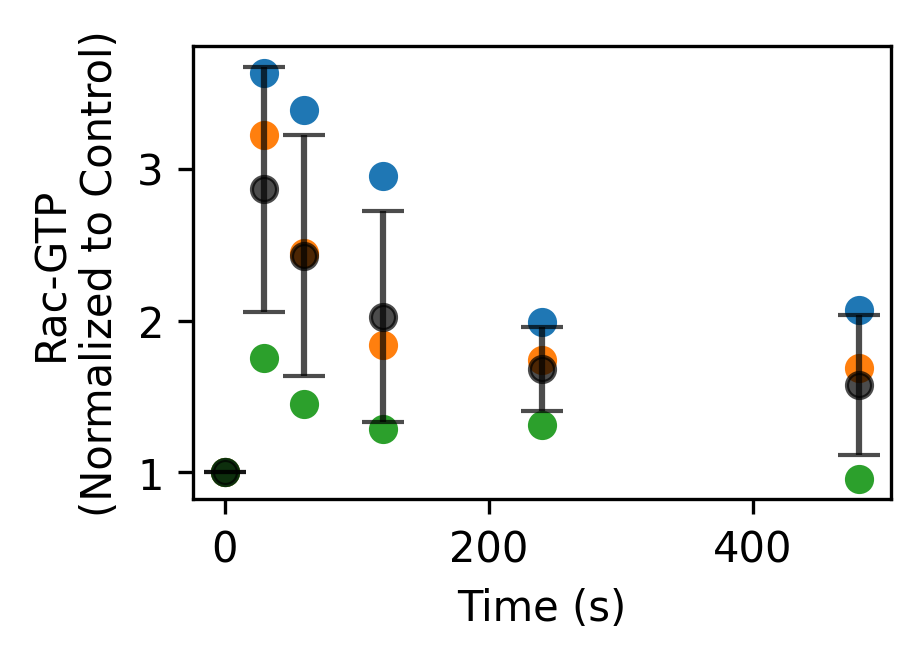

In [2]:
plt.figure(figsize = (3, 2), dpi =300)
ax = plt.subplot()


x = np.array([0, 30, 60, 120, 240, 480])
series1 = np.array([1.873, 5.168, 4.869, 4.322, 3.112, 3.214])
series2 = np.array([1.406, 3.153, 2.544, 2.066, 1.989, 1.95])


blank = np.average([.598, .639])


norms = []
for i in [series1, series2]:
    norm_i = (i - blank)/(i[0] - blank)
    plt.scatter(x, norm_i)

    norms.append(norm_i)

series3 = [1, 1.75047619, 1.45142857, 1.28952381, 1.31428571, 0.96]
plt.scatter(x, series3)
norms.append(series3)

m = np.average(norms, axis = 0)
s = np.std(norms, axis = 0)
plt.scatter(x, m, color= 'k', alpha = 0.7)
plt.errorbar(x, m, s, color= 'k', ls = '', capsize = 5, alpha = 0.7)

plt.ylabel('Rac-GTP\n(Normalized to Control)')
plt.xlabel('Time (s)')

plt.show()

# Figure S9C

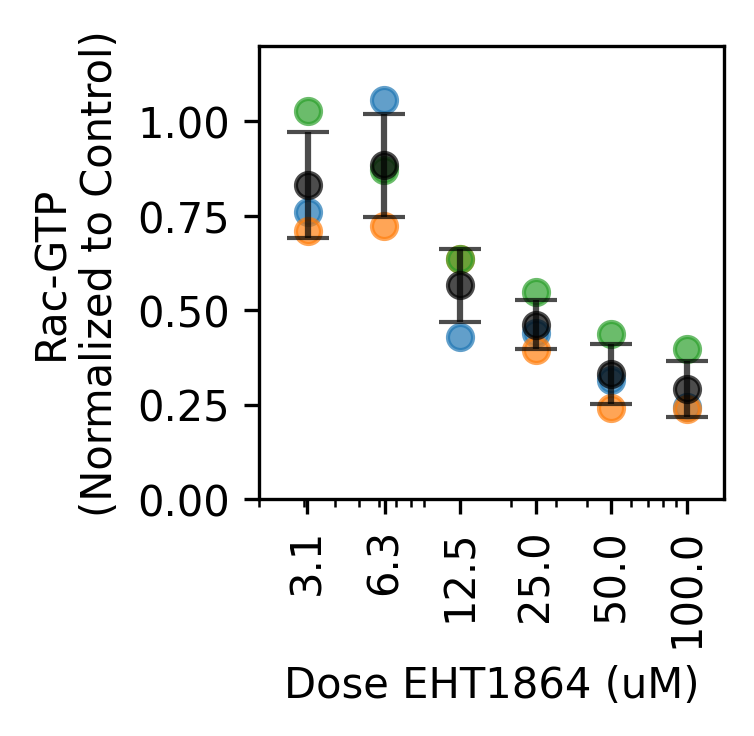

[1.         0.83193705 0.88359759 0.56621253 0.46119814 0.33122448
 0.29219665]


In [5]:
plt.figure(figsize = (2, 2), dpi =300)
ax = plt.subplot()

x = np.array([0, 0, 3.125, 6.25, 12.5, 25, 50, 100])
series1 = np.array([1.816, 2.607, 2.128, 2.719, 1.473, 1.493, 1.247, 1.101])
series2 = np.array([2.163, 1.729, 1.406, 1.422, 1.323, 1.057, .887, .882])
series3 = np.array([1.275, 1.308, 1.327, 1.219, 1.056, .997, .919, .892])

blank = np.average([.598, .639])
norms = []
for i in [series1, series2, series3]:
    norm_i = (i[1:] - blank)/(i[1] - blank)
    plt.scatter(x[1:], norm_i, alpha = 0.7)
    norms.append(norm_i)
    
    

m = np.average(norms, axis = 0)
s = np.std(norms, axis = 0)
plt.scatter(x[1:], m, color= 'k', alpha = 0.7)
plt.errorbar(x[1:], m, s, color= 'k', ls = '', capsize = 5, alpha = 0.7)
plt.xscale('log')
plt.xticks([3.1, 6.3, 12.5, 25, 50, 100], rotation = 'vertical')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.ylim(0, 1.2)
plt.xlim(2, 140)

plt.ylabel('Rac-GTP\n(Normalized to Control)')
plt.xlabel('Dose EHT1864 (uM)')
plt.show()


print(m)

# Figure S9D

In [6]:
upper_dir = 'data/fig04data/201003_EHT1864_RacAdaptation/'


# controls
filtered_files = np.sort([upper_dir + i for i in os.listdir(upper_dir) if ('_0uM_' in i) and ('._' not in i)])
print(filtered_files)

normed_ch0_ehtcon = []
normed_ch1_ehtcon = []

for ff in filtered_files:
    a = mm_acquisition(ff)
    for i in a.single_cell_ch0_filtered:
        normed_ch0_ehtcon.append(i/np.average(i[20:30]))
    for i in a.single_cell_ch1_filtered:
        normed_ch1_ehtcon.append(i/np.average(i[20:30]))
        
# 6.25 uM treated
filtered_files = np.sort([upper_dir + i for i in os.listdir(upper_dir) if ('_06.25uM_' in i)])
print(filtered_files)

normed_ch0_ehttrt1 = []
normed_ch1_ehttrt1 = []

for ff in filtered_files:
    a = mm_acquisition(ff)
    for i in a.single_cell_ch0_filtered:
        normed_ch0_ehttrt1.append(i/np.average(i[20:30]))
    for i in a.single_cell_ch1_filtered:
        normed_ch1_ehttrt1.append(i/np.average(i[20:30]))
        
# 12.5 uM treated
filtered_files = np.sort([upper_dir + i for i in os.listdir(upper_dir) if ('_12.50uM_' in i) and ('._' not in i)])
print(filtered_files)

normed_ch0_ehttrt2 = []
normed_ch1_ehttrt2 = []

for ff in filtered_files:
    a = mm_acquisition(ff)
    for i in a.single_cell_ch0_filtered:
        normed_ch0_ehttrt2.append(i/np.average(i[20:30]))
    for i in a.single_cell_ch1_filtered:
        normed_ch1_ehttrt2.append(i/np.average(i[20:30]))
        
        
# 25 uM treated
filtered_files = np.sort([upper_dir + i for i in os.listdir(upper_dir) if ('_25uM' in i)|('25.00' in i)])
print(filtered_files)

normed_ch0_ehttrt3 = []
normed_ch1_ehttrt3 = []

for ff in filtered_files:
    a = mm_acquisition(ff)
    for i in a.single_cell_ch0_filtered:
        normed_ch0_ehttrt3.append(i/np.average(i[20:30]))
    for i in a.single_cell_ch1_filtered:
        normed_ch1_ehttrt3.append(i/np.average(i[20:30]))
        
# 50 uM treated
filtered_files = np.sort([upper_dir + i for i in os.listdir(upper_dir) if ('_50uM' in i)|('50.00' in i)])
print(filtered_files)

normed_ch0_ehttrt4 = []
normed_ch1_ehttrt4 = []

for ff in filtered_files:
    a = mm_acquisition(ff)
    for i in a.single_cell_ch0_filtered:
        normed_ch0_ehttrt4.append(i/np.average(i[20:30]))
    for i in a.single_cell_ch1_filtered:
        normed_ch1_ehttrt4.append(i/np.average(i[20:30]))
        
        
# 100 uM treated
filtered_files = np.sort([upper_dir + i for i in os.listdir(upper_dir) if ('_100uM' in i)])
print(filtered_files)

normed_ch0_ehttrt5 = []
normed_ch1_ehttrt5 = []

for ff in filtered_files:
    a = mm_acquisition(ff)
    for i in a.single_cell_ch0_filtered:
        normed_ch0_ehttrt5.append(i/np.average(i[20:30]))
    for i in a.single_cell_ch1_filtered:
        normed_ch1_ehttrt5.append(i/np.average(i[20:30]))

['data/fig4data/201003_EHT1864_RacAdaptation/201001_RacInhibitor_0uM_EHT1864_PulseOptoResponse_3'
 'data/fig4data/201003_EHT1864_RacAdaptation/201001_RacInhibitor_0uM_EHT1864_PulseOptoResponse_4'
 'data/fig4data/201003_EHT1864_RacAdaptation/201001_RacInhibitor_0uM_EHT1864_PulseOptoResponse_7'
 'data/fig4data/201003_EHT1864_RacAdaptation/201003_35-52-97-mCherryPAK_EHT1864_0uM_1'
 'data/fig4data/201003_EHT1864_RacAdaptation/201003_35-52-97-mCherryPAK_EHT1864_0uM_2']
['data/fig4data/201003_EHT1864_RacAdaptation/201001_RacInhibitor_06.25uM_EHT1864_PulseOptoResponse_1']
['data/fig4data/201003_EHT1864_RacAdaptation/201001_RacInhibitor_12.50uM_EHT1864_PulseOptoResponse_1']
['data/fig4data/201003_EHT1864_RacAdaptation/201001_RacInhibitor_25.00uM_EHT1864_PulseOptoResponse_1'
 'data/fig4data/201003_EHT1864_RacAdaptation/201001_RacInhibitor_25.00uM_EHT1864_PulseOptoResponse_2'
 'data/fig4data/201003_EHT1864_RacAdaptation/201001_RacInhibitor_25.00uM_EHT1864_PulseOptoResponse_4'
 'data/fig4data/201

172
51
45
333
266
21


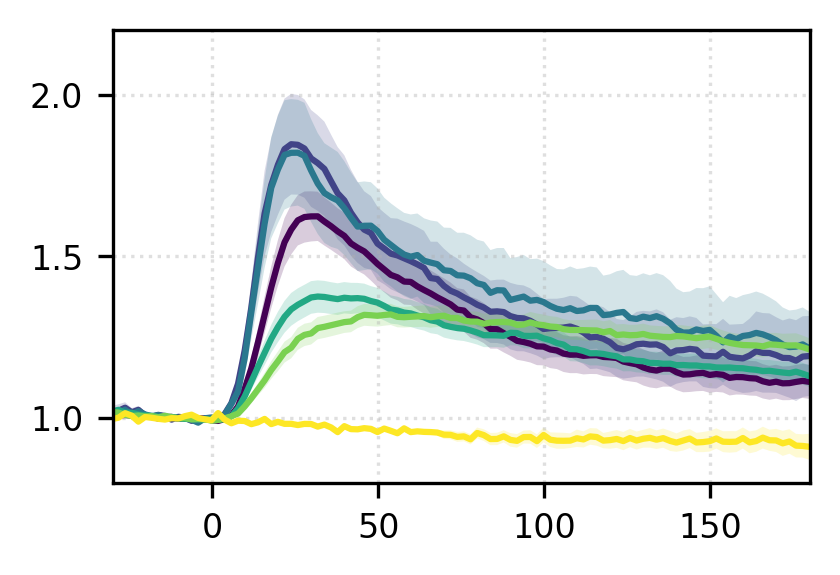

In [9]:
plt.figure(figsize = (3, 2), dpi = 300)

ax = plt.subplot()

after_three_min = []

cmap = cm.get_cmap('viridis')
cvec = [cmap(i) for i in np.linspace(0, 1, 6)]
linestyles = ['-', '--', ':']
which_channel = [1, 0, 0]
labels = ['Control', '6.25 μM', '12.5 μM', '25 μM', '50 μM', '100 μM']

peaks = []
peaks_std = []

end_points = []
end_points_std = []

t1 = a.elapsedtimes[a.channels == 1] - 60.

count = 0
for i in [normed_ch1_ehtcon, normed_ch1_ehttrt1, normed_ch1_ehttrt2, normed_ch1_ehttrt3, normed_ch1_ehttrt4, normed_ch1_ehttrt5]:
    responders = [j for j in i if np.max(j[30:]) > 1.]
    
    print(len(responders))
    
    m1 = np.average(responders, axis = 0) 
    
    
    s1 = (1.96*np.std(responders, axis = 0)/np.sqrt(len(responders)))
    
    plt.plot(t1, m1, color = cvec[count])
    plt.fill_between(t1, m1 - s1, m1 + s1, alpha = 0.2, facecolor = cvec[count])
    
    count += 1
    
    peaks.append(m1[np.argmax(m1)])
    peaks_std.append(s1[np.argmax(m1)])

plt.xlim(-30, 180)
plt.ylim(0.8, 2.2)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.grid(ls = ':', alpha = 0.4)
plt.show()

172
51
45
333
266
21


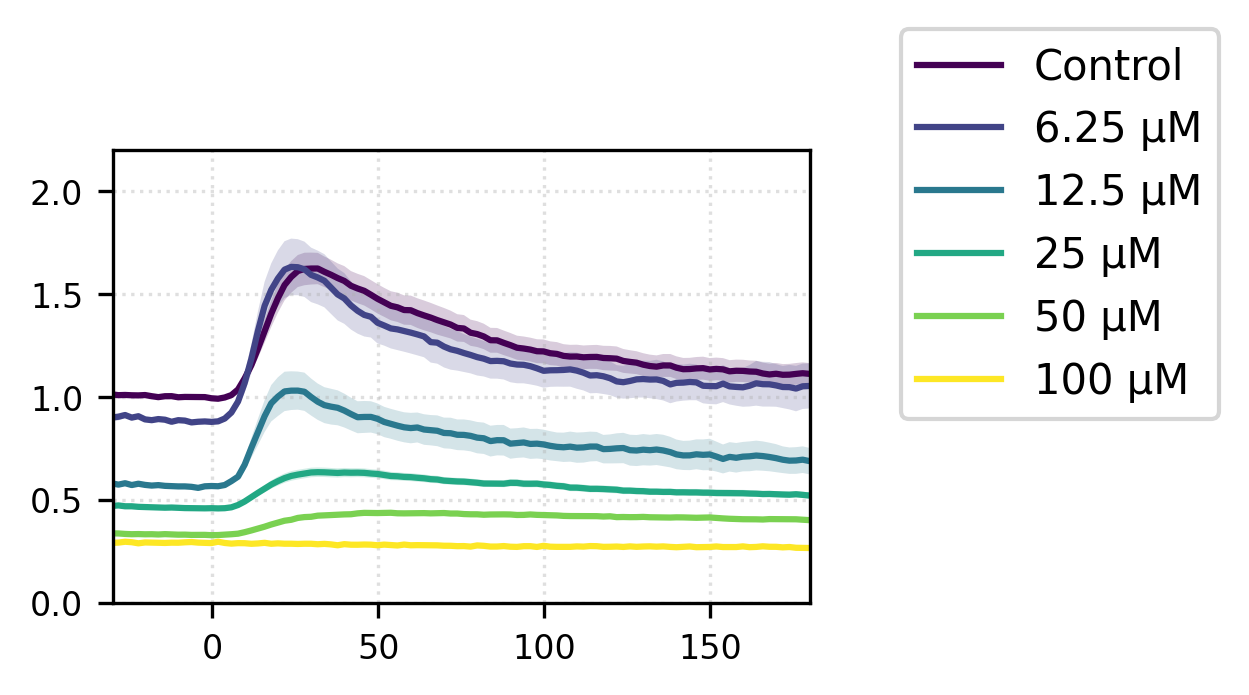

In [10]:
# these were copied from above, but the 3.1 uM dose is missing from live cell data
multiplier = np.array([1., 0.88359759, 0.56621253, 0.46119814, 0.33122448, 0.29219665])


plt.figure(figsize = (3, 2), dpi = 300)

ax = plt.subplot()

after_three_min = []

cmap = cm.get_cmap('viridis')
cvec = [cmap(i) for i in np.linspace(0, 1, 6)]
linestyles = ['-', '--', ':']
which_channel = [1, 0, 0]
labels = ['Control', '6.25 μM', '12.5 μM', '25 μM', '50 μM', '100 μM']

peaks = []
peaks_std = []

end_points = []
end_points_std = []


glisa_normed = []


for_csv = [t1]
count = 0
for i in [normed_ch1_ehtcon, normed_ch1_ehttrt1, normed_ch1_ehttrt2, normed_ch1_ehttrt3, normed_ch1_ehttrt4, normed_ch1_ehttrt5]:
    responders = [j for j in i if np.max(j[30:]) > 1.]
    
    print(len(responders))
    
    m1 = np.average(responders, axis = 0)  * multiplier[count]
    
    
    s1 = (1.96*np.std(responders, axis = 0)/np.sqrt(len(responders))) * multiplier[count]
    
    plt.plot(t1, m1, color = cvec[count], label = labels[count])
    plt.fill_between(t1, m1 - s1, m1 + s1, alpha = 0.2, facecolor = cvec[count])
    
    for_csv.append(m1)
    for_csv.append(s1)
    
    count += 1
    
    glisa_normed.append(m1)
    
    peaks.append(m1[np.argmax(m1)])
    peaks_std.append(s1[np.argmax(m1)])
    
plt.xlim(-30, 180)
plt.ylim(0.0, 2.2)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.grid(ls = ':', alpha = 0.4)

plt.legend(bbox_to_anchor = (1.1, 0.36))
plt.show()
